In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# DenseNet121 Model for Dermnet Dataset
* This model is to be used for DermAI
* DermAI is an AI-powered dermatological assistant designed to provide users with a preliminary diagnosis of skin conditions before visiting a dermatologist
* This project will be submitted to HOSA SLC 2025

In [2]:
import torch
from torch import nn, optim
import torchvision
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import os
import numpy
import tqdm 

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and DataLoaders

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
trainset = datasets.ImageFolder('/kaggle/input/dermnet/train', transform=data_transforms) 
testset = datasets.ImageFolder('/kaggle/input/dermnet/test', transform=data_transforms)

# Create DataLoaders
train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
test_loader = DataLoader(testset, batch_size=16, shuffle=False)

Label: Tinea Ringworm Candidiasis and other Fungal Infections


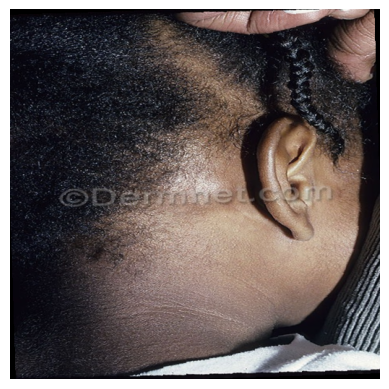

In [4]:
# Showing Images with Labels
import matplotlib.pyplot as plt
import numpy as np

# Function to show images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert tensor to numpy and rearrange dimensions
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to be in the valid range
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a few images
for i in range(1):  # Display first 5 images
    print(f"Label: {trainset.classes[labels[i]]}")  # Print the corresponding label
    imshow(images[i])

# Model Initialization

In [5]:
model = models.densenet121(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 155MB/s] 


In [6]:
# Replace classification layers
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(trainset.classes))
)

# Move model to device
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training and Evaluating Model

In [8]:
from tqdm import tqdm
import torch.nn.functional as F

# Function to calculate Top-1 and Top-5 accuracy
def accuracy(output, target, topk=(1,5)):
    """Computes the top-k accuracy for the specified values of k."""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)  # Get top-k predictions
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))  # Check if predictions match the target

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))  # Convert to percentage
        return res

# Training and Validation Loop
num_epochs = 10  # Adjust as needed
# Store results for plotting
train_acc1_history = []
train_acc5_history = []
val_acc1_history = []
val_acc5_history = []

best_val_acc1 = 0  # Track the best validation accuracy

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    tqdm_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    
    for images, labels in tqdm_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute accuracy
        acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
        correct_top1 += acc1.item() * labels.size(0) / 100
        correct_top5 += acc5.item() * labels.size(0) / 100
        total += labels.size(0)
        
        running_loss += loss.item() * labels.size(0)
        tqdm_train.set_postfix(loss=running_loss / total, top1=correct_top1 / total, top5=correct_top5 / total)

    train_acc1 = correct_top1 / total * 100
    train_acc5 = correct_top5 / total * 100
    train_acc1_history.append(train_acc1)
    train_acc5_history.append(train_acc5)

    # Validation Phase
    model.eval()
    val_correct_top1 = 0
    val_correct_top5 = 0
    val_total = 0
    val_loss = 0.0

    tqdm_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    
    with torch.no_grad():
        for images, labels in tqdm_val:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            
            # Compute accuracy
            acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
            val_correct_top1 += acc1.item() * labels.size(0) / 100
            val_correct_top5 += acc5.item() * labels.size(0) / 100
            val_total += labels.size(0)

            tqdm_val.set_postfix(loss=val_loss / val_total, top1=val_correct_top1 / val_total, top5=val_correct_top5 / val_total)

    val_acc1 = val_correct_top1 / val_total * 100
    val_acc5 = val_correct_top5 / val_total * 100
    val_loss /= val_total
    val_acc1_history.append(val_acc1)
    val_acc5_history.append(val_acc5)

    # Step scheduler
    scheduler.step(val_loss)

    # Save the best model based on validation accuracy
    if val_acc1 > best_val_acc1:
        best_val_acc1 = val_acc1
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved new best model with Val Top-1 Accuracy: {best_val_acc1:.2f}%")

Epoch 1/10 [Training]:   0%|          | 4/973 [00:08<33:52,  2.10s/it, loss=3.12, top1=0.109, top5=0.266]   


KeyboardInterrupt: 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

# Function to calculate Top-1 and Top-5 accuracy
def accuracy(output, target, topk=(1,5)):
    """Computes the top-k accuracy for the specified values of k."""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)  # Get top-k predictions
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))  # Check if predictions match the target

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))  # Convert to percentage
        return res

# Load the best saved model
model.load_state_dict(torch.load("/kaggle/input/dermai_model/pytorch/default/1/best_model.pth"))
model.to(device)
model.train()  # Set model to training mode

# Define new training loop for continued training
epoch = 0
num_new_epochs = 7  # Adjust as needed

best_top1_acc = 0.0  # Track the best Top-1 accuracy

for epoch in range(num_new_epochs):
    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    tqdm_train = tqdm(train_loader, desc=f"Epoch {epoch+1} [Continued Training]")

    for images, labels in tqdm_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute accuracy
        acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
        correct_top1 += acc1.item() * labels.size(0) / 100
        correct_top5 += acc5.item() * labels.size(0) / 100
        total += labels.size(0)

        running_loss += loss.item() * labels.size(0)
        tqdm_train.set_postfix(loss=running_loss / total, top1=correct_top1 / total, top5=correct_top5 / total)

    epoch_top1_acc = correct_top1 / total * 100
    print(f"Epoch {epoch+1}: Loss = {running_loss / total:.4f}, Top-1 Acc = {epoch_top1_acc:.2f}%, Top-5 Acc = {correct_top5 / total * 100:.2f}%")
    
    # Save the model if it has the best Top-1 accuracy so far
    if epoch_top1_acc > best_top1_acc:
        best_top1_acc = epoch_top1_acc
        torch.save(model.state_dict(), "best_model_continued.pth")
        print(f"New best model saved with Top-1 Acc = {best_top1_acc:.2f}%")
    

# Save the newly trained model
torch.save(model.state_dict(), "best_model_continued.pth")
print("Training complete. Model saved as best_model_continued.pth.")

<ipython-input-10-5b79a49a3970>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/dermai_model/pytorch/default/1/best_model.p

Epoch 1: Loss = 0.8451, Top-1 Acc = 74.10%, Top-5 Acc = 95.26%
New best model saved with Top-1 Acc = 74.10%


Epoch 2 [Continued Training]: 100%|██████████| 973/973 [16:51<00:00,  1.04s/it, loss=0.784, top1=0.757, top5=0.959]


Epoch 2: Loss = 0.7845, Top-1 Acc = 75.75%, Top-5 Acc = 95.91%
New best model saved with Top-1 Acc = 75.75%


Epoch 3 [Continued Training]: 100%|██████████| 973/973 [16:48<00:00,  1.04s/it, loss=0.729, top1=0.775, top5=0.966]


Epoch 3: Loss = 0.7288, Top-1 Acc = 77.53%, Top-5 Acc = 96.60%
New best model saved with Top-1 Acc = 77.53%


Epoch 4 [Continued Training]: 100%|██████████| 973/973 [16:51<00:00,  1.04s/it, loss=0.671, top1=0.791, top5=0.97] 


Epoch 4: Loss = 0.6709, Top-1 Acc = 79.12%, Top-5 Acc = 97.04%
New best model saved with Top-1 Acc = 79.12%


Epoch 5 [Continued Training]: 100%|██████████| 973/973 [17:07<00:00,  1.06s/it, loss=0.6, top1=0.81, top5=0.976]   


Epoch 5: Loss = 0.5999, Top-1 Acc = 81.02%, Top-5 Acc = 97.65%
New best model saved with Top-1 Acc = 81.02%


Epoch 6 [Continued Training]: 100%|██████████| 973/973 [17:08<00:00,  1.06s/it, loss=0.548, top1=0.826, top5=0.982]


Epoch 6: Loss = 0.5482, Top-1 Acc = 82.58%, Top-5 Acc = 98.20%
New best model saved with Top-1 Acc = 82.58%


Epoch 7 [Continued Training]: 100%|██████████| 973/973 [17:09<00:00,  1.06s/it, loss=0.528, top1=0.83, top5=0.984] 


Epoch 7: Loss = 0.5283, Top-1 Acc = 83.01%, Top-5 Acc = 98.39%
New best model saved with Top-1 Acc = 83.01%
Training complete. Model saved as best_model_continued.pth.


In [11]:
torch.save(model.state_dict(), "Finished_model.pth")

In [15]:
# Validation Phase
model.eval()
val_correct_top1 = 0
val_correct_top5 = 0
val_total = 0
val_loss = 0.0

tqdm_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")

with torch.no_grad():
    for images, labels in tqdm_val:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * labels.size(0)
        
        # Compute accuracy
        acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
        val_correct_top1 += acc1.item() * labels.size(0) / 100
        val_correct_top5 += acc5.item() * labels.size(0) / 100
        val_total += labels.size(0)

        tqdm_val.set_postfix(loss=val_loss / val_total, top1=val_correct_top1 / val_total, top5=val_correct_top5 / val_total)

val_acc1 = val_correct_top1 / val_total * 100
val_acc5 = val_correct_top5 / val_total * 100
val_loss /= val_total

Epoch 7/10 [Validation]: 100%|██████████| 251/251 [02:34<00:00,  1.63it/s, loss=1.44, top1=0.641, top5=0.89] 


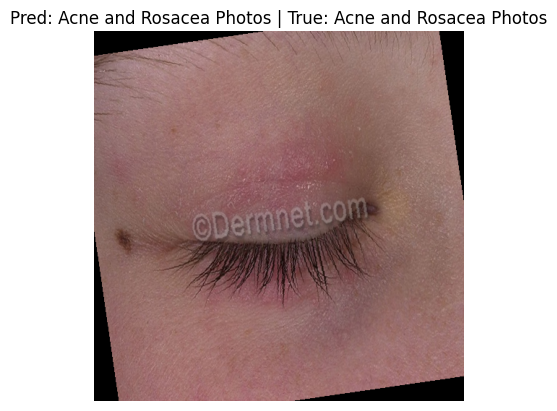

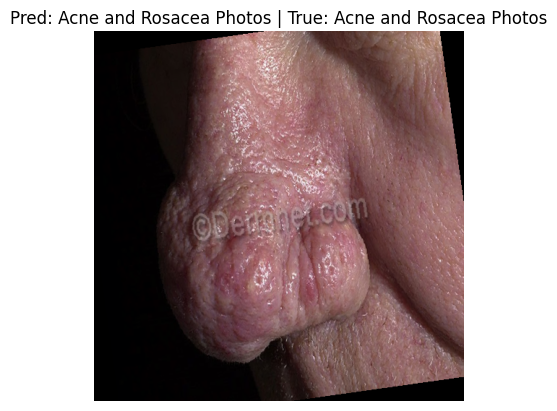

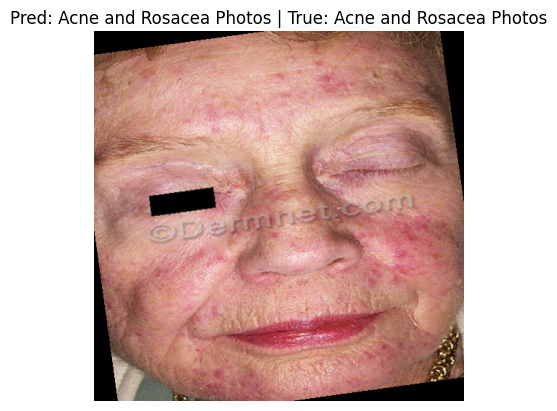

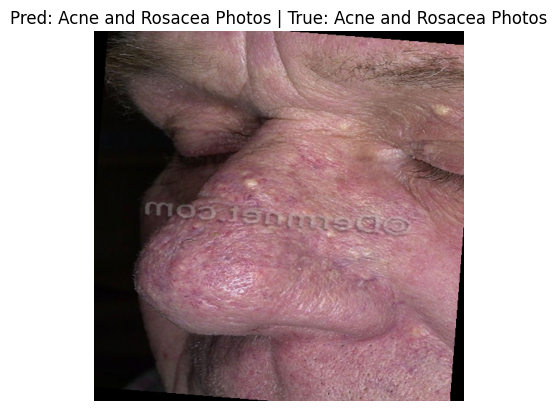

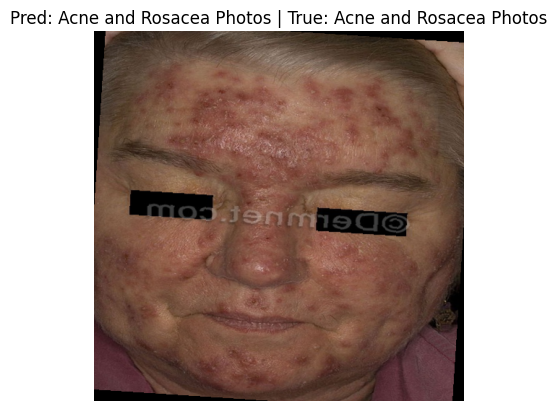

In [13]:
# Function to visualize predictions
def show_predictions(model, dataloader, num_images=3):
    model.eval()
    images_shown = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the highest prediction
            
            for i in range(num_images):
                img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to NumPy
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
                plt.title(f"Pred: {trainset.classes[preds[i]]} | True: {trainset.classes[labels[i]]}")
                plt.axis("off")
                plt.show()
                
                images_shown += 1
                if images_shown >= num_images:
                    return  # Stop after showing required images

# Show predictions
show_predictions(model, test_loader, num_images=5)